# Efficiency/Effectiveness Trade-offs in Learning to Rank
### Tutorial @ ECML PKDD 2018, HandsOn Session N. 2

##### Claudio Lucchese (UniVe), Franco Maria Nardini (ISTI-CNR)
##### High Performance Computing Lab. http://hpc.isti.cnr.it/

<img src="images/hpc.png" width="250">

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import xarray as xr

from rankeval.dataset import Dataset
from rankeval.model import RTEnsemble
from rankeval.metrics import NDCG
from rankeval.analysis.effectiveness import tree_wise_performance
from rankeval.visualization.effectiveness import plot_tree_wise_performance
from rankeval.analysis.effectiveness import model_performance

### Agenda

 0. Train the optimal **LambdaMart** model and evaluate its effectiveness and efficiency
 0. Removing and optimizing trees with **Cleaver**
 0. Improving effectiveness with **DART**
 0. Improving efficiency with **X-Dart**
 0. From cond-op/Vpred to **QuickScorer**
 0. From QuickScorer to **V-QuickScorer**

### Prerequisites

 - Quickrank, see installation instructions. https://github.com/hpclab/quickrank
 - Install Quickscorer (private HPC git) master branch under NDA. http://learningtorank.isti.cnr.it/
 - Install RankEval, see installation instructions. https://github.com/hpclab/rankeval 
 - Download the Istella-S LETOR dataset. http://blog.istella.it/istella-learning-to-rank-dataset/

In [ ]:
# Global Options

# paths to executable files
QUICKRANK = "./quickrank/bin/quicklearn"
SCORER    = "./quickrank/bin/quickscore"

QUICKSCORER = "./QuickScorer/bin/quickscorer"
QUICKSCORER_GPU = "./QuickScorer-GPU/GPUQS/bin/quickscorer"

# paths to Istella-S dataset
train_dataset_file = "/data/letor-datasets/tiscali/sample/ramfs/train.txt"
valid_dataset_file = "/data/letor-datasets/tiscali/sample/ramfs/vali.txt"
test_dataset_file  = "/data/letor-datasets/tiscali/sample/ramfs/test.txt"

# paths to model file
models_folder            = "models"
baseline_model_file      = os.path.join(models_folder, "istella-small.lamdamart.xml")
cleaver_model_file       = os.path.join(models_folder, "istella-small.lamdamart.cleaver.xml")

dart_model_file          = os.path.join(models_folder, "istella-small.dart.xml")
xdart_model_file         = os.path.join(models_folder, "istella-small.xdart.xml")

small_dart_model_file    = os.path.join(models_folder, "istella-small.dart.small.xml")
small_xdart_model_file   = os.path.join(models_folder, "istella-small.xdart.small.xml")

# setting floating point precision of Pandas
pd.set_option('precision', 4)

### Train the optimal LambdaMart model and evaluate its effectiveness and efficiency

[LambdaMart] can be considered the state of the art algorithm.

**Note:** As training takes a lot of time, we already trained a model for you and made it available at http://learningtorank.isti.cnr.it/models/istella-small_models.tar.gz so that you can skip the training step.

In [ ]:
!{QUICKRANK} \
    --train {train_dataset_file} \
    --valid {valid_dataset_file} \
    --model-out {baseline_model_file} \
    --num-trees 1500 \
    --num-leaves 64 \
    --shrinkage 0.05

#### Evaluate the effectiveness of the model on train, validation and test datasets

In [ ]:
# load istella-S dataset
train_dataset = Dataset.load(train_dataset_file, name="train")
valid_dataset = Dataset.load(valid_dataset_file, name="valid")
test_dataset  = Dataset.load(test_dataset_file, name="test")

In [ ]:
# load the model
baseline_model = RTEnsemble(baseline_model_file, name="LambdaMart", format="QuickRank")

In [ ]:
# define metric
ndcg_10 = NDCG(cutoff=10, 
               no_relevant_results=0.0) # assign score 0 to queries without relevant docs

In [11]:
# measure NDCG every 20 trees
tree_wise_perf = tree_wise_performance( datasets =[train_dataset, valid_dataset, test_dataset], 
                                        models   =[baseline_model],
                                        metrics  =[ndcg_10],
                                        step=20)

IntProgress(value=0, description=u'Computing metrics', max=225)

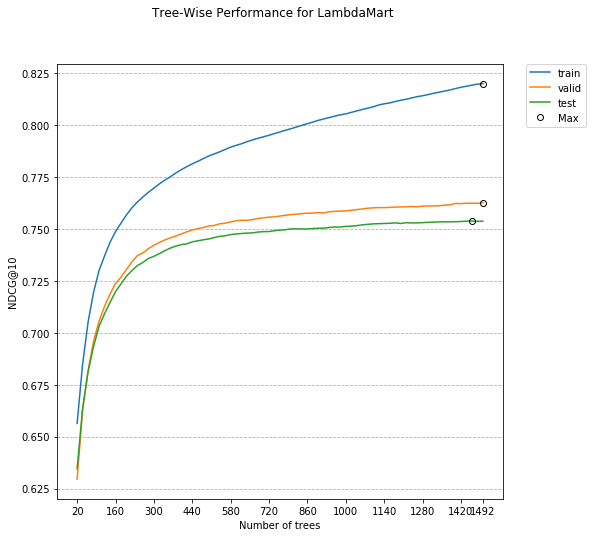

In [12]:
fig_list = plot_tree_wise_performance(tree_wise_perf, compare = "datasets")

In [13]:
tree_wise_perf.loc[{'dataset':test_dataset}].to_dataframe()

dataset  Tree-Wise Performance
model      k    metric                                
LambdaMart 20   NDCG@10    test                 0.6345
           40   NDCG@10    test                 0.6634
           60   NDCG@10    test                 0.6812
           80   NDCG@10    test                 0.6934
           100  NDCG@10    test                 0.7030
           120  NDCG@10    test                 0.7091
           140  NDCG@10    test                 0.7146
           160  NDCG@10    test                 0.7198
           180  NDCG@10    test                 0.7235
           200  NDCG@10    test                 0.7272
           220  NDCG@10    test                 0.7299
           240  NDCG@10    test                 0.7323
           260  NDCG@10    test                 0.7338
           280  NDCG@10    test                 0.7357
           300  NDCG@10    test                 0.7368
           320  NDCG@10    test                 0.7381
           340  NDCG@10    test                 0.7395
           360  NDCG@10    test                 0.7407
           380  NDCG@10    test                 0.7417
           400  NDCG@10    test                 0.7424
           420  NDCG@10    test                 0.7427
           440  NDCG@10    test                 0.7437
           460  NDCG@10    test                 0.7442
           480  NDCG@10    test                 0.7447
           500  NDCG@10    test                 0.7451
           520  NDCG@10    test                 0.7458
           540  NDCG@10    test                 0.7464
           560  NDCG@10    test                 0.7466
           580  NDCG@10    test                 0.7472
           600  NDCG@10    test                 0.7475
...                         ...                    ...
           920  NDCG@10    test                 0.7503
           940  NDCG@10    test                 0.7506
           960  NDCG@10    test                 0.7509
           980  NDCG@10    test                 0.7509
           1000 NDCG@10    test                 0.7512
           1020 NDCG@10    test                 0.7513
           1040 NDCG@10    test                 0.7515
           1060 NDCG@10    test                 0.7519
           1080 NDCG@10    test                 0.7521
           1100 NDCG@10    test                 0.7524
           1120 NDCG@10    test                 0.7525
           1140 NDCG@10    test                 0.7526
           1160 NDCG@10    test                 0.7527
           1180 NDCG@10    test                 0.7529
           1200 NDCG@10    test                 0.7526
           1220 NDCG@10    test                 0.7529
           1240 NDCG@10    test                 0.7528
           1260 NDCG@10    test                 0.7528
           1280 NDCG@10    test                 0.7530
           1300 NDCG@10    test                 0.7531
           1320 NDCG@10    test                 0.7532
           1340 NDCG@10    test                 0.7533
           1360 NDCG@10    test                 0.7534
           1380 NDCG@10    test                 0.7533
           1400 NDCG@10    test                 0.7534
           1420 NDCG@10    test                 0.7535
           1440 NDCG@10    test                 0.7537
           1460 NDCG@10    test                 0.7537
           1480 NDCG@10    test                 0.7536
           1492 NDCG@10    test                 0.7537

[75 rows x 2 columns]

In [14]:
baseline_effectiveness = tree_wise_perf.loc[{'dataset':test_dataset,
                                             'model':baseline_model, 
                                             'metric':ndcg_10}].values[-1]

#### Evaluate the efficiency of the model

In [15]:
# We use Con-Op based C code as a baseline for the scoring time evaluation

def run_condop(model_file, dataset_file, rounds=1):
    condop_source = model_file + ".c"
    condop_compiled = model_file + ".bin"

    # create the C code
    print (" 1. Creating the C code for " + model_file)
    
    _ = !{QUICKRANK} \
      --generator condop \
      --model-file {model_file} \
      --code-file {condop_source}
    
    # Compile an executable ranker. The resulting ranker is SCORER=./quickrank/bin/quickscore
    print (" 2. Compiling the model")

    # actually compule only if the model is newer
    if ( not os.path.exists(condop_compiled) or 
         os.path.getmtime(condop_compiled)<os.path.getmtime(baseline_model_file) ):
        # replace empty scorer
        !cp {condop_source} ./quickrank/src/scoring/ranker.cc
        # compile
        _ = !make -j -C ./quickrank/build_ quickscore 
        # copy compiled scorer
        !cp {SCORER} {condop_compiled}
    
    # Run the compiled model
    print (" 3. Running the compiled model")
    scorer_out = !{condop_compiled} \
      -d {dataset_file} \
      -r {rounds}
    
    print (scorer_out.n)
    
    # takes the scoring time in milli-seconds
    scoring_time = float(scorer_out.l[-1].split()[-2])* 10**6
    
    return scoring_time

In [16]:
baseline_efficiency = run_condop(baseline_model_file, test_dataset_file)

 1. Creating the C code for models/istella-small.lamdamart.xml
 2. Compiling the model
 3. Running the compiled model

      _____  _____
     /    / /____/
    /____\ /    \          QuickRank has been developed by hpc.isti.cnr.it
    ::Quick:Rank::                                   quickrank@isti.cnr.it

#	 Dataset size: 681250 x 220 (instances x features)
#	 Num queries: 6562 | Avg. len: 104
       Total scoring time: 74.4 s.
Avg. Dataset scoring time: 74.4 s.
Avg.    Doc. scoring time: 0.000109 s.


In [17]:
# Store current results
results = pd.DataFrame(columns=['Model', '# Trees', 'NDCG@10', 'Doc. Scoring Time µs.'])

results.loc[len(results)] = [baseline_model.name, baseline_model.n_trees, baseline_effectiveness, baseline_efficiency]
results

,Model,# Trees,NDCG@10,Doc. Scoring Time µs.
0,LambdaMart,1492,0.7537,109.0


### Pruning and optimizing trees with Cleaver

[Cleaver] is a pruning algorithm removes the trees in a given forest that contribute less and fine-tunes the weights of the remaining ones. Here we apply such pruning to the LambdaMart model just built. 

<img src="images/cleaver.png" width=700>

#### Evaluate the effectiveness of the model

Cleaver is implemented by QuickRank. See documentation here: https://github.com/hpclab/quickrank/blob/master/documentation/cleaver.md.

In [ ]:
pruning_rate = 0.5
!{QUICKRANK}\
    --model-in {baseline_model_file} \
    --train {train_dataset_file} \
    --valid {valid_dataset_file} \
    --opt-algo CLEAVER \
    --opt-method QUALITY_LOSS_ADV \
    --pruning-rate {pruning_rate} \
    --with-line-search \
    --num-samples 20 \
    --window-size 10 \
    --reduction-factor 0.95 \
    --max-iterations 100 \
    --max-failed-valid 20 \
    --adaptive \
    --opt-algo-model {cleaver_model_file}

In [18]:
cleaver_model = RTEnsemble(cleaver_model_file, name="Cleaver", format="QuickRank")

IntProgress(value=0, description=u'Computing metrics', max=113)

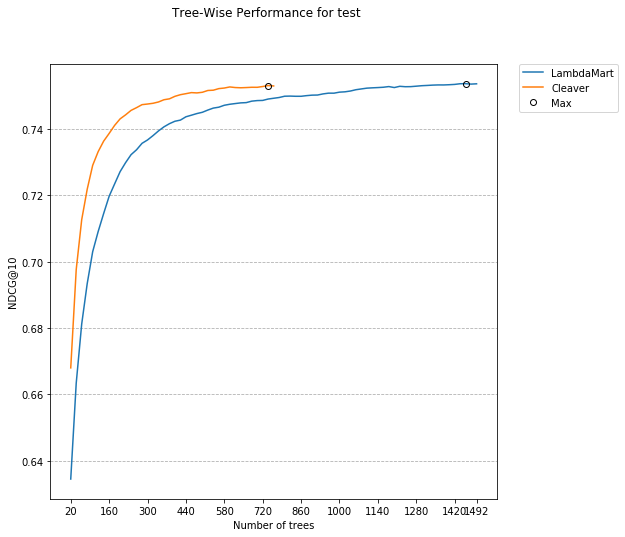

In [19]:
# measure NDCG
tree_wise_perf = tree_wise_performance(datasets=[test_dataset], 
                                        models=[baseline_model, cleaver_model],
                                        metrics=[ndcg_10],
                                        step=20)
fig_list = plot_tree_wise_performance(tree_wise_perf, compare = "models")

In [20]:
models_perf = model_performance(datasets=[test_dataset], 
                                 models=[cleaver_model, baseline_model], 
                                 metrics=[ndcg_10])
models_perf.to_dataframe()

Model Performance
dataset model      metric                    
test    Cleaver    NDCG@10             0.7530
        LambdaMart NDCG@10             0.7537

In [21]:
from rankeval.analysis.statistical import statistical_significance
stat_sig = statistical_significance(datasets=[test_dataset],
                                    model_a=cleaver_model, model_b=baseline_model, 
                                    metrics=[ndcg_10],
                                    n_perm=100000 )
stat_sig.to_dataframe()

IntProgress(value=0, description=u'Iterating datasets and metrics', max=1)

IntProgress(value=0, description=u'Randomization Test', max=10)

Statistical Significance
dataset metric  p-value                            
test    NDCG@10 one-sided                    0.1973
                two-sided                    0.3927

We conclude difference is not statistically significant. The model built by Cleaver can be used instead of the LambdaMart model.

In [22]:
cleaver_effectiveness = float( models_perf.loc[{'model':cleaver_model, 
                                                'dataset':test_dataset, 
                                                'metric':ndcg_10}] )

#### Evaluate the efficiency of the model

In [23]:
cleaver_efficiency = run_condop(cleaver_model_file, test_dataset_file)

 1. Creating the C code for models/istella-small.lamdamart.cleaver.xml
 2. Compiling the model
 3. Running the compiled model

      _____  _____
     /    / /____/
    /____\ /    \          QuickRank has been developed by hpc.isti.cnr.it
    ::Quick:Rank::                                   quickrank@isti.cnr.it

#	 Dataset size: 681250 x 220 (instances x features)
#	 Num queries: 6562 | Avg. len: 104
       Total scoring time: 32.9 s.
Avg. Dataset scoring time: 32.9 s.
Avg.    Doc. scoring time: 4.83e-05 s.


In [24]:
results.loc[len(results)] = [cleaver_model.name, cleaver_model.n_trees, cleaver_effectiveness, cleaver_efficiency]
results

,Model,# Trees,NDCG@10,Doc. Scoring Time µs.
0,LambdaMart,1492,0.7537,109.0
1,Cleaver,746,0.7530,48.3


### Improving effectiveness with DART

[Dart] expoits a *dropout* strategy temporarily muting trees during training. Dart is thus able to produce higher quality models. Our goal is to build a smaller model providing the same quality as the baseline model.

<img src="images/dart.png">

#### Evaluate the effectiveness of the model

Dart is implemented by QuickRank. See documentation here: https://github.com/hpclab/quickrank/blob/master/documentation/xdart.md.

**Note:** As training takes a lot of time, we already trained a model for you and made it available at http://learningtorank.isti.cnr.it/models/istella-small_models.tar.gz so that you can skip the training step.

In [ ]:
# Train Dart with QuickRank
!{QUICKRANK} \
  --algo DART \
  --train {train_dataset_file} \
  --valid {valid_dataset_file} \
  --model-out {dart_model_file} \
  --num-trees 1500 \
  --num-leaves 64 \
  --shrinkage 1.0 \
  --sample-type UNIFORM \
  --normalize-type TREE \
  --adaptive-type FIXED \
  --rate-drop 0.015

In [25]:
# load Dart Models
dart_model = RTEnsemble(dart_model_file, name="Dart", format="QuickRank")

IntProgress(value=0, description=u'Computing metrics', max=171)

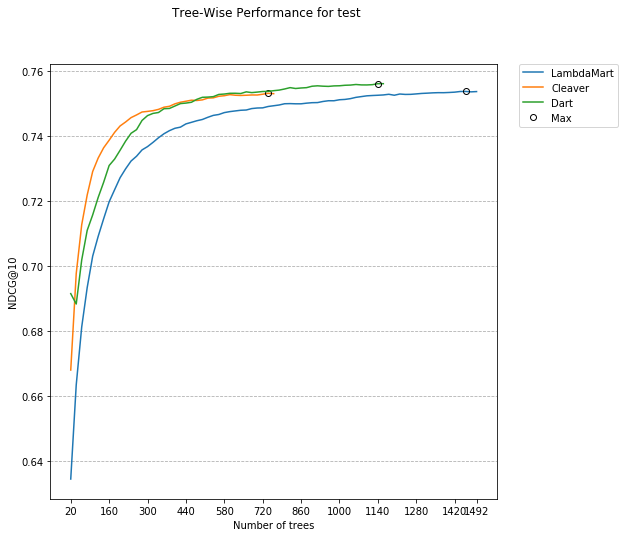

In [26]:
# measure NDCG
tree_wise_perf = tree_wise_performance(datasets=[test_dataset], 
                                        models=[baseline_model, cleaver_model, dart_model],
                                        metrics=[ndcg_10],
                                        step=20)
fig_list = plot_tree_wise_performance(tree_wise_perf, compare = "models")

In [27]:
# we want at least the same effectiveness as the baseline model
tree_wise_perf.loc[{'model':dart_model, 'k':range(700,800,20)}].to_dataframe()

model  Tree-Wise Performance
dataset k   metric                              
test    700 NDCG@10  Dart                 0.7535
        720 NDCG@10  Dart                 0.7537
        740 NDCG@10  Dart                 0.7537
        760 NDCG@10  Dart                 0.7540
        780 NDCG@10  Dart                 0.7541

In [28]:
small_dart_trees = 760
small_dart = dart_model.copy(n_trees=small_dart_trees)
small_dart.save(small_dart_model_file)

small_dart_effectiveness = float( tree_wise_perf.loc[{'model':dart_model, 'k':small_dart_trees, 'metric':ndcg_10}].values )

#### Evaluate the efficiency of the model

In [29]:
small_dart_efficiency = run_condop(small_dart_model_file, test_dataset_file)

 1. Creating the C code for models/istella-small.dart.small.xml
 2. Compiling the model
 3. Running the compiled model

      _____  _____
     /    / /____/
    /____\ /    \          QuickRank has been developed by hpc.isti.cnr.it
    ::Quick:Rank::                                   quickrank@isti.cnr.it

#	 Dataset size: 681250 x 220 (instances x features)
#	 Num queries: 6562 | Avg. len: 104
       Total scoring time: 32.5 s.
Avg. Dataset scoring time: 32.5 s.
Avg.    Doc. scoring time: 4.78e-05 s.


In [30]:
results.loc[len(results)] = [small_dart.name, small_dart.n_trees, small_dart_effectiveness, small_dart_efficiency]
results

,Model,# Trees,NDCG@10,Doc. Scoring Time µs.
0,LambdaMart,1492,0.7537,109.0
1,Cleaver,746,0.7530,48.3
2,Dart,760,0.7540,47.8


## Improving efficiency with X-Dart

[XDart] extends the idea of Dart by allowing the permanent removal of trees: muted dropout trees are permanently removed if they are outperformed by a single newly learnt tree.

<img src="images/xdart.png">

#### Evaluate the effectiveness of the model

X-Dart is implemented by QuickRank. See documentation here: https://github.com/hpclab/quickrank/blob/master/documentation/xdart.md.

**Note:** As training takes a lot of time, we already trained a model for you and made it available at http://learningtorank.isti.cnr.it/models/istella-small_models.tar.gz so that you can skip the training step.

In [ ]:
# Train X-Dart with QuickRank
!{QUICKRANK} \
  --algo DART \
  --train {train_dataset_file} \
  --valid {valid_dataset_file} \
  --model-out {xdart_model_file} \
  --num-trees 1500 \
  --num-leaves 64 \
  --shrinkage 1.0 \
  --sample-type UNIFORM \
  --normalize-type TREE \
  --adaptive-type PLUSHALF_RESET_LB1_UB5 \
  --rate-drop 1.0 \
  --keep-drop \
  --drop-on-best

In [31]:
xdart_model = RTEnsemble(xdart_model_file, name="X-Dart", format="QuickRank")

IntProgress(value=0, description=u'Computing metrics', max=207)

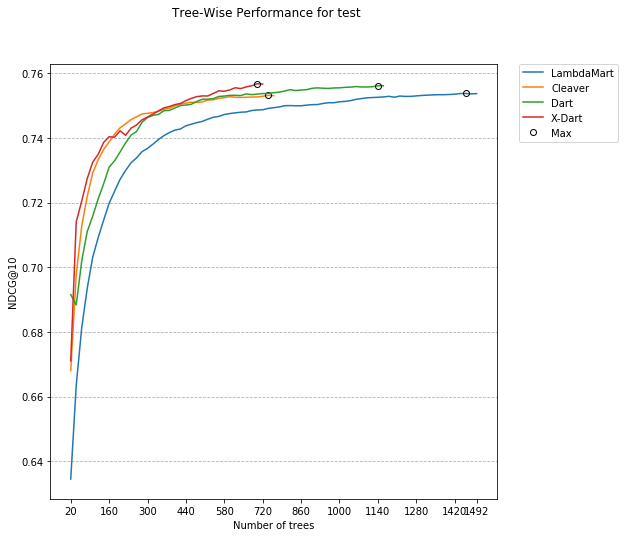

In [32]:
# measure NDCG
tree_wise_perf = tree_wise_performance(datasets=[test_dataset], 
                                        models=[baseline_model, cleaver_model, dart_model, xdart_model],
                                        metrics=[ndcg_10],
                                        step=20)
fig_list = plot_tree_wise_performance(tree_wise_perf, compare = "models")

In [33]:
# we want at least the same effectiveness as the baseline model
tree_wise_perf.loc[{'model':xdart_model, 'k':range(500,720,20)}].to_dataframe()

model  Tree-Wise Performance
dataset k   metric                                
test    500 NDCG@10  X-Dart                 0.7530
        520 NDCG@10  X-Dart                 0.7530
        540 NDCG@10  X-Dart                 0.7537
        560 NDCG@10  X-Dart                 0.7545
        580 NDCG@10  X-Dart                 0.7544
        600 NDCG@10  X-Dart                 0.7548
        620 NDCG@10  X-Dart                 0.7555
        640 NDCG@10  X-Dart                 0.7552
        660 NDCG@10  X-Dart                 0.7558
        680 NDCG@10  X-Dart                 0.7561
        700 NDCG@10  X-Dart                 0.7568

In [34]:
small_xdart_trees = 560
small_xdart = xdart_model.copy(n_trees=small_xdart_trees)
small_xdart.save(small_xdart_model_file)

small_xdart_effectiveness = float( tree_wise_perf.loc[{'model':xdart_model, 'k':small_xdart_trees, 'metric':ndcg_10}].values )

#### Evaluate the efficiency of the model

In [35]:
small_xdart_efficiency = run_condop(small_xdart_model_file, test_dataset_file)

 1. Creating the C code for models/istella-small.xdart.small.xml
 2. Compiling the model
 3. Running the compiled model

      _____  _____
     /    / /____/
    /____\ /    \          QuickRank has been developed by hpc.isti.cnr.it
    ::Quick:Rank::                                   quickrank@isti.cnr.it

#	 Dataset size: 681250 x 220 (instances x features)
#	 Num queries: 6562 | Avg. len: 104
       Total scoring time: 22.4 s.
Avg. Dataset scoring time: 22.4 s.
Avg.    Doc. scoring time: 3.28e-05 s.


In [36]:
results.loc[len(results)] = [small_xdart.name, small_xdart.n_trees, small_xdart_effectiveness, small_xdart_efficiency]
results

,Model,# Trees,NDCG@10,Doc. Scoring Time µs.
0,LambdaMart,1492,0.7537,109.0
1,Cleaver,746,0.7530,48.3
2,Dart,760,0.7540,47.8
3,X-Dart,560,0.7545,32.8


### Exploiting QuickScorer to speed-up the scoring time

[QuickScorer] uses a novel traversal methods and a cache-friendly data layout that reduces dramatically the traversal time.


In [37]:
target_model_file = small_xdart_model_file
target_model = small_xdart
target_model.name = "QuickScorer"
target_model_effectiveness = small_xdart_effectiveness

In [38]:
scorer_out = !{QUICKSCORER} \
  -d {test_dataset_file} \
  -m {target_model_file} \
  -l 64 \
  -r 1 \
  -t 0

# -l : max number of leaves
# -r : rounds
# -t : tree type (e.g. oblivious)
    
print (scorer_out.n)
    
# takes the scoring time in milli-seconds
scoring_time = float(scorer_out.l[-1].split()[-2])* 10**6


      _____  _____
     /    / /____
    /____\ _____/          QuickScorer has been developed by hpc.isti.cnr.it
    :Quick:Scorer:                                   quickscorer@isti.cnr.it

#	 Dataset size: 681250 x 220 (instances x features)
#	 Num queries: 6562 | Avg. len: 104
       Total scoring time: 6.86648 s.
Avg. Dataset scoring time: 6.86648 s.
Avg.    Doc. scoring time: 1.00792e-05 s.


In [39]:
results.loc[len(results)] = [target_model.name, target_model.n_trees, target_model_effectiveness, scoring_time]
results

,Model,# Trees,NDCG@10,Doc. Scoring Time µs.
0,LambdaMart,1492,0.7537,109.0000
1,Cleaver,746,0.7530,48.3000
2,Dart,760,0.7540,47.8000
3,X-Dart,560,0.7545,32.8000
4,QuickScorer,560,0.7545,10.0792


### Exploiting QuickScorer to speed-up the scoring time

[V-QuickScorer] improves over QuickScorer by exploiting 256-bits wide CPU registers.


In [40]:
scorer_out = !{QUICKSCORER} \
  -d {test_dataset_file} \
  -m {target_model_file} \
  -l 64 \
  -r 1 \
  -t 3 \
  -v 8 \
  --avx

# -v : 8 docs in parallel

print (scorer_out.n)
    
# takes the scoring time in milli-seconds
scoring_time = float(scorer_out.l[-1].split()[-2])* 10**6


      _____  _____
     /    / /____
    /____\ _____/          QuickScorer has been developed by hpc.isti.cnr.it
    :Quick:Scorer:                                   quickscorer@isti.cnr.it

#	 Dataset size: 681250 x 220 (instances x features)
#	 Num queries: 6562 | Avg. len: 104
       Total scoring time: 4.0699 s.
Avg. Dataset scoring time: 4.0699 s.
Avg.    Doc. scoring time: 5.97416e-06 s.


In [41]:
results.loc[len(results)] = ['V-QS', target_model.n_trees, target_model_effectiveness, scoring_time]
results

,Model,# Trees,NDCG@10,Doc. Scoring Time µs.
0,LambdaMart,1492,0.7537,109.0000
1,Cleaver,746,0.7530,48.3000
2,Dart,760,0.7540,47.8000
3,X-Dart,560,0.7545,32.8000
4,QuickScorer,560,0.7545,10.0792
5,V-QS,560,0.7545,5.9742


In [42]:
results["Speed-up"] = results["Doc. Scoring Time µs."][0]/ results["Doc. Scoring Time µs."]
results

,Model,# Trees,NDCG@10,Doc. Scoring Time µs.,Speed-up
0,LambdaMart,1492,0.7537,109.0000,1.0000
1,Cleaver,746,0.7530,48.3000,2.2567
2,Dart,760,0.7540,47.8000,2.2803
3,X-Dart,560,0.7545,32.8000,3.3232
4,QuickScorer,560,0.7545,10.0792,10.8144
5,V-QS,560,0.7545,5.9742,18.2452


### Exploiting GPU-QuickScorer to speed-up the scoring time

[GPU-QuickScorer] improves over QuickScorer by exploiting GPU multi-threading.


In [43]:
scorer_out = !{QUICKSCORER_GPU} \
  -d {test_dataset_file} \
  -m {target_model_file} \
  -t 1 -l 64 -r 10 -b 4000 -y 384 -z 16384

print (scorer_out.n)
    
# takes the scoring time in milli-seconds
scoring_time = float(scorer_out.l[-2].split()[-2])* 10**6


      _____  _____
     /    / /____
    /____\ _____/          QuickScorer has been developed by Tiscali SpA, CNR, Univ. of Pisa, Univ. of Venezia
    :Quick:Scorer:                                                                      quickscorer@isti.cnr.it

#	 Dataset size: 681250 x 220 (instances x features)
#	 Num queries: 6562 | Avg. len: 104
Using a GPU-based strategy!
GPU INFO: Mem free at START: 12600672256 (total: 12782075904)
Building the model...
Scoring...
GPU => # of trees 560 (max per block: 4000)
GPU => size treeIDs + masks + thresholds: 564480 bytes
GPU => size vec temporary offsets: 884 bytes
GPU => size tree score table: 286720 bytes
GPU => size doc result scores: 5450000 bytes
GPU => Size of a block of instances processed at once: 305040
GPU => Global memory reserved for the block of instances: 1073740800 bytes
GPU => Executing 16384 blocks, 384 threads per block
GPU => 32000 bytes shared mem allocated x CUDA-block
GPU => Processing docs [0-305040) (305040 docs)
GP

In [44]:
results.loc[len(results)] = ['GPU-QS', target_model.n_trees, target_model_effectiveness, scoring_time, 0]
results["Speed-up"] = results["Doc. Scoring Time µs."][0]/ results["Doc. Scoring Time µs."]
results

,Model,# Trees,NDCG@10,Doc. Scoring Time µs.,Speed-up
0,LambdaMart,1492,0.7537,109.0000,1.0000
1,Cleaver,746,0.7530,48.3000,2.2567
2,Dart,760,0.7540,47.8000,2.2803
3,X-Dart,560,0.7545,32.8000,3.3232
4,QuickScorer,560,0.7545,10.0792,10.8144
5,V-QS,560,0.7545,5.9742,18.2452
6,GPU-QS,560,0.7545,0.2718,400.9948


***

### References

  [LambdaMart] Christopher J.C. Burges. From ranknet to lambdarank to lambdamart: An overview. Technical Report MSR-TR-2010-82, June 2010.

  [Dart] Korlakai Vinayak, R. & Gilad-Bachrach, R. (2015). DART: Dropouts meet Multiple Additive Regression Trees. Proceedings of the Eighteenth International Conference on Artificial Intelligence and Statistics, in PMLR 38:489-497

  [XDart] Lucchese, C., Nardini, F. M., Orlando, S., Perego, R., & Trani, S. (2017). X-DART: Blending Dropout and Pruning for Efficient Learning to Rank. In Proceedings of the 40th International ACM SIGIR Conference on Research and Development in Information Retrieval (pp. 1077-1080). ACM.
  
  [Cleaver] Lucchese, C., Nardini, F. M., Orlando, S., Perego, R., Silvestri, F., & Trani, S. (2016). Post-learning optimization of tree ensembles for efficient ranking. In Proceedings of the 39th International ACM SIGIR conference on Research and Development in Information Retrieval (pp. 949-952). ACM.
  
  [QuickScorer] Lucchese, C., Nardini, F. M., Orlando, S., Perego, R., Tonellotto, N., & Venturini, R. (2015, August). Quickscorer: A fast algorithm to rank documents with additive ensembles of regression trees. In Proceedings of the 38th International ACM SIGIR Conference on Research and Development in Information Retrieval (pp. 73-82). ACM.
  
  [V-QuickScorer] Lucchese, C., Nardini, F. M., Orlando, S., Perego, R., Tonellotto, N., & Venturini, R. (2016, July). Exploiting CPU SIMD extensions to speed-up document scoring with tree ensembles. In Proceedings of the 39th International ACM SIGIR conference on Research and Development in Information Retrieval (pp. 833-836). ACM.
  
  [GPU-QuickScorer] Lettich, F., Lucchese, C., Nardini, F. M., Orlando, S., Perego, R., Tonellotto, N., & Venturini, R. (2018). Parallel Traversal of Large Ensembles of Decision Trees. IEEE Transactions on Parallel and Distributed Systems.
